<a href="https://colab.research.google.com/github/gokceuludogan/protein-ml-crash-course/blob/main/Chapter_2_Protein_Structure_Contact_Graphs_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 25.3 MB/s eta 0:00:00


# Chapter 2: Protein Structure - Contact Graphs and Clustering

## Overview

In this chapter, we will explore the 3D structure of proteins and represent it using contact graphs. Protein structures are often analyzed by looking at the proximity of amino acids in 3D space. A contact graph is a representation where each amino acid (node) is connected to others if they are within a certain distance (edge). We'll also apply clustering algorithms to group similar regions of the protein structure based on the graph and finally compute secondary structure elements (SSEs) and overlay them on the contact graph visualization.

We will:

- Parse a protein structure from a PDB file.
- Build a contact graph based on proximity of amino acids.
- Apply clustering algorithms to group amino acids.
- Compute secondary structures using DSSP and visualize them in the contact graph.

---

## 1. Loading Protein Structures (PDB Files)

Protein 3D structures are stored in **PDB (Protein Data Bank)** format. The PDB file contains atomic coordinates that describe the position of each atom in space.

### Example of PDB Format:

```mathematica
mathematica
Copy code
ATOM      1  N   MET A   1      44.457  18.686  19.226  1.00  0.00           N
ATOM      2  CA  MET A   1      43.186  19.260  18.784  1.00  0.00           C
ATOM      3  C   MET A   1      42.954  18.976  17.297  1.00  0.00           C
...

```

###  Example: Loading a PDB File

We’ll use the `biopython` library to parse PDB files and extract atom coordinates.

In [12]:
from Bio.PDB import PDBParser

import requests
from io import StringIO
from Bio import PDB

def fetch_pdb_from_api(pdb_id):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    if response.status_code == 200:
        pdb_file = StringIO(response.text)
        with open(f'{pdb_id}.pdb', 'w') as f:
          f.write(response.text)
        parser = PDB.PDBParser(QUIET=True)
        structure = parser.get_structure('protein', pdb_file)
        return structure
    else:
        raise Exception(f"Failed to fetch PDB file: {response.status_code}")


def load_pdb(file_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', file_path)
    return structure

# Example usage
# pdb_file = "example.pdb"
# structure = load_pdb(pdb_file)

# Example usage
pdb_id = "1UBQ"  # Replace with the desired PDB ID
structure = fetch_pdb_from_api(pdb_id)


## 2. Building a Contact Graph

A **contact map** represents the distances between all pairs of amino acids in a protein structure. If two amino acids are within a threshold distance (e.g., 8 Ångströms), an edge is created between them in the contact graph.

### Steps:

1. Extract the C-alpha atom coordinates (one for each amino acid).
2. Compute pairwise distances between the C-alpha atoms.
3. Build a contact map by applying a distance threshold.
4. Represent the contact map as a graph where nodes are amino acids, and edges indicate proximity.

### Example: Building the Contact Graph

In [13]:
import numpy as np
import networkx as nx
from Bio.PDB import PDBParser

def get_ca_atoms(structure):
    # Extract C-alpha atoms from the structure
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    ca_atoms.append(residue['CA'].get_coord())
    return np.array(ca_atoms)

def build_contact_graph(ca_coords, threshold=8.0):
    # Build contact graph based on distance threshold
    num_atoms = len(ca_coords)
    graph = nx.Graph()

    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            distance = np.linalg.norm(ca_coords[i] - ca_coords[j])
            if distance <= threshold:
                graph.add_edge(i, j)
    return graph

# Example usage
ca_atoms = get_ca_atoms(structure)
contact_graph = build_contact_graph(ca_atoms)


## 3. Visualizing the Contact Graph

We can use the **NetworkX** library to visualize the contact graph. Each node represents an amino acid, and edges represent contacts between amino acids that are close to each other.

### Example: Graph Visualization

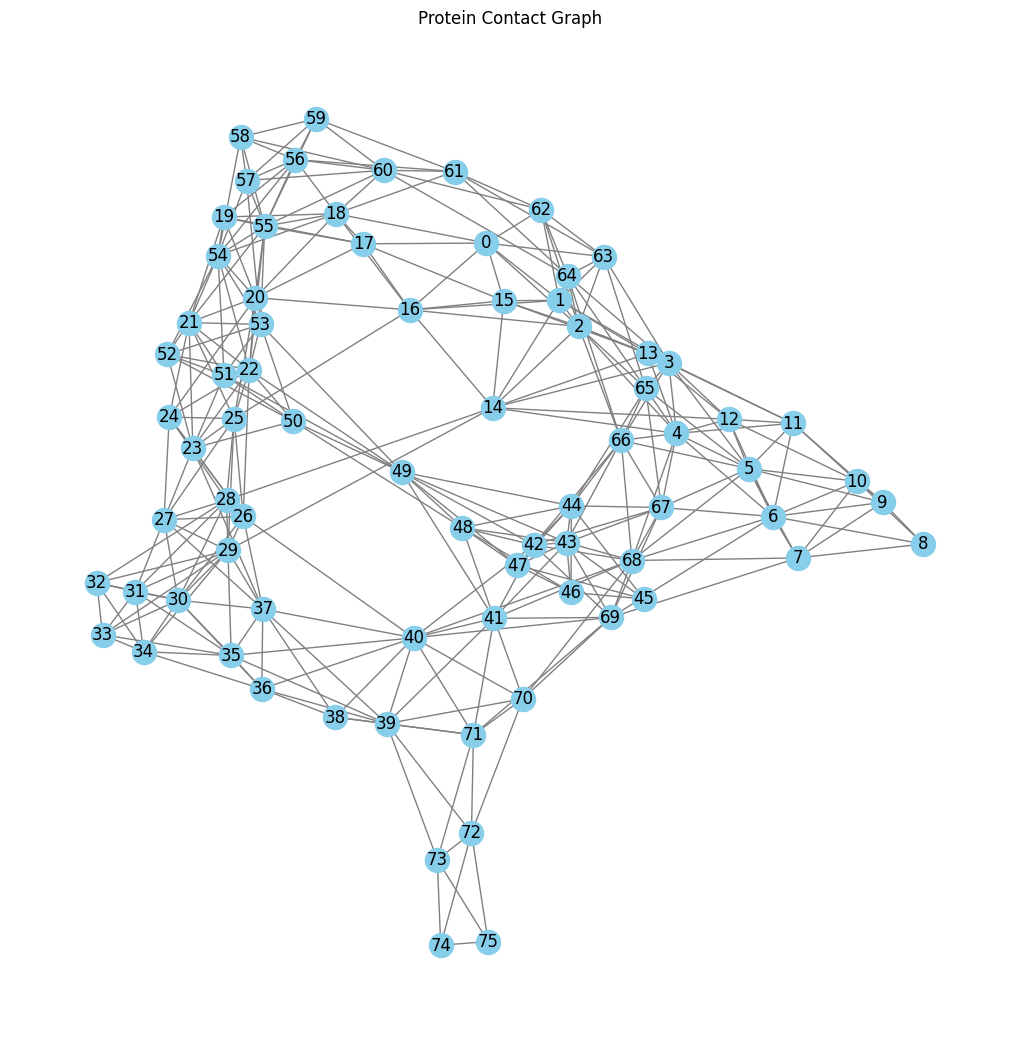

In [14]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_contact_graph(graph):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)  # Layout for graph visualization
    nx.draw(graph, pos, with_labels=True, node_size=300, node_color='skyblue', edge_color='gray')
    plt.title("Protein Contact Graph")
    plt.show()

# Example usage
visualize_contact_graph(contact_graph)


## 4. Clustering Amino Acids using Graph Clustering

We can apply graph clustering algorithms to group amino acids based on their connectivity in the contact graph. This approach takes advantage of the graph structure we've already created. A popular graph clustering algorithm is the Louvain method, which optimizes modularity.

### Steps:

1. Use the contact graph as input to a graph clustering algorithm.
2. Group amino acids based on their connections in the graph.

### Clustering with Louvain Method

In [15]:
import networkx as nx
from community import community_louvain

def cluster_amino_acids(contact_graph):
    # Apply Louvain method for graph clustering
    partition = community_louvain.best_partition(contact_graph)
    return partition

# Example usage
clusters = cluster_amino_acids(contact_graph)
print("Cluster labels for each amino acid:", clusters)

Cluster labels for each amino acid: {0: 0, 1: 0, 2: 0, 15: 0, 16: 0, 17: 1, 18: 1, 62: 0, 63: 0, 3: 0, 13: 0, 14: 0, 64: 0, 4: 2, 65: 0, 66: 2, 5: 2, 11: 2, 12: 2, 6: 2, 67: 2, 68: 2, 7: 2, 9: 2, 10: 2, 8: 2, 69: 3, 28: 5, 29: 5, 20: 1, 25: 5, 19: 1, 55: 1, 54: 1, 56: 1, 60: 1, 61: 1, 21: 1, 22: 1, 24: 5, 23: 1, 51: 1, 52: 1, 53: 1, 26: 5, 49: 4, 50: 1, 27: 5, 37: 3, 30: 5, 40: 3, 31: 5, 32: 5, 33: 5, 34: 5, 35: 5, 36: 3, 39: 3, 38: 3, 71: 3, 41: 3, 70: 3, 72: 3, 73: 3, 42: 4, 43: 4, 48: 4, 44: 4, 45: 4, 46: 4, 47: 4, 57: 1, 58: 1, 59: 1, 74: 3, 75: 3}


This approach uses the graph structure to identify communities of amino acids that are more densely connected to each other than to the rest of the graph. It can reveal functional or structural modules within the protein.

## 5. Visualizing Clusters

Once the amino acids are clustered, we can visualize the clusters on the contact graph by coloring the nodes based on their cluster membership.

### Visualizing Clusters on the Contact Graph

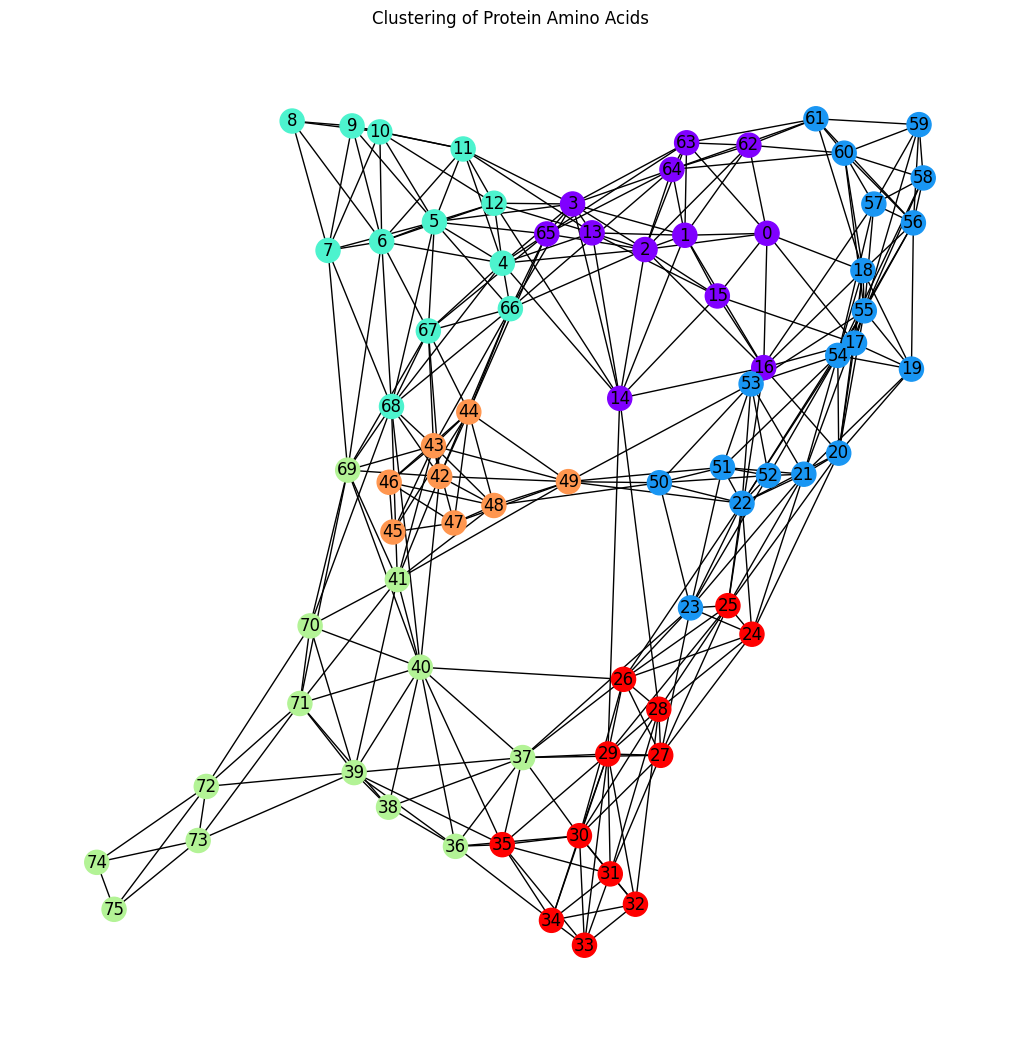

In [16]:
def visualize_clusters(graph, clusters):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)
    node_colors = [clusters[node] for node in graph.nodes()]
    nx.draw(graph, pos, node_color=node_colors, with_labels=True, cmap=plt.cm.rainbow)
    plt.title("Clustering of Protein Amino Acids")
    plt.show()

# Example usage
visualize_clusters(contact_graph, clusters)



## 6. Computing Secondary Structures using DSSP
Now, we will compute secondary structure elements (SSEs) using the DSSP tool and integrate this information into our contact graph visualization. DSSP classifies secondary structure into alpha-helices, beta-sheets, and more.

### Installing DSSP and Computing Secondary Structure with DSSP

In [8]:
!apt-get install dssp

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcifpp-data libcifpp2
The following NEW packages will be installed:
  dssp libcifpp-data libcifpp2
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,967 kB of archives.
After this operation, 15.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcifpp-data all 2.0.5-1build1 [437 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcifpp2 amd64 2.0.5-1build1 [1,019 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 dssp amd64 4.0.4-1 [511 kB]
Fetched 1,967 kB in 1s (1,875 kB/s)
Preconfiguring packages ...
Selecting previously unselected package libcifpp-data.
(Reading database ... 123605 files and directories currently installed.)
Preparing to unpack .../libcifpp-data_2.0.5-1build1_all.deb ...
Unpacking libcifpp-data (2.0.5-1bu

In [36]:
from Bio.PDB import DSSP

# Applying DSSP to compute secondary structure elements
model = structure[0]  # Use the first model in the structure
dssp = DSSP(model , f'{pdb_id}.pdb')

# Extracting secondary structure information
secondary_structure = []
for ix, residue in enumerate(dssp):
    aa, ss = residue[1], residue[2]  # Amino acid and secondary structure assignment
    secondary_structure.append((ix, aa, ss))

# Print the secondary structure summary
for (i, aa, ss) in secondary_structure[:10]:
    print(f"Residue {i+1}: Amino Acid = {aa}, Secondary Structure = {ss}")

Residue 1: Amino Acid = M, Secondary Structure = -
Residue 2: Amino Acid = Q, Secondary Structure = E
Residue 3: Amino Acid = I, Secondary Structure = E
Residue 4: Amino Acid = F, Secondary Structure = E
Residue 5: Amino Acid = V, Secondary Structure = E
Residue 6: Amino Acid = K, Secondary Structure = E
Residue 7: Amino Acid = T, Secondary Structure = E
Residue 8: Amino Acid = L, Secondary Structure = T
Residue 9: Amino Acid = T, Secondary Structure = T
Residue 10: Amino Acid = G, Secondary Structure = S


## 7. Visualizing Secondary Structure in the Contact Graph
We will color the nodes of the contact graph based on their secondary structure (e.g., red for alpha-helices, blue for beta-sheets).

### Visualizing Secondary Structure on the Contact Graph

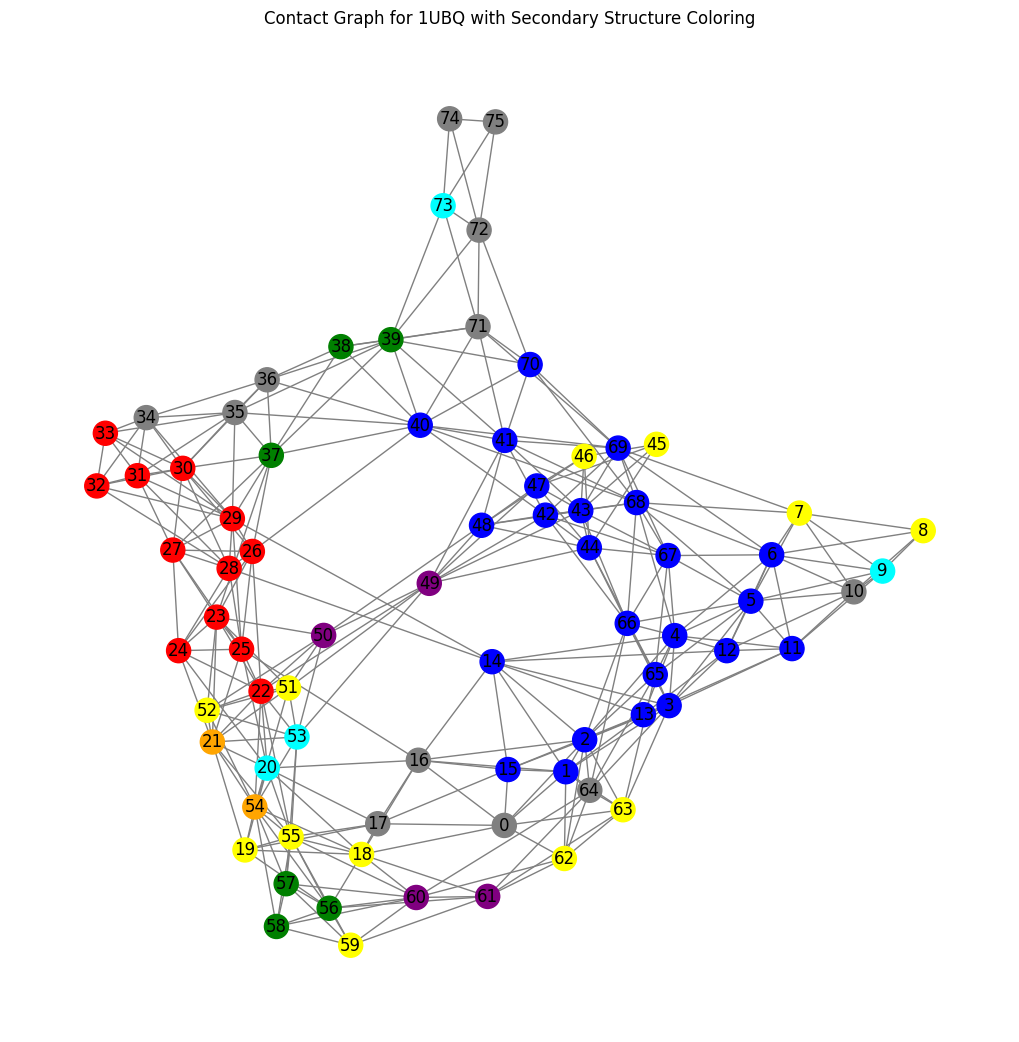

In [34]:
# Map secondary structure types to colors
ss_colors = {
    'H': 'red',    # Alpha helix
    'E': 'blue',   # Beta strand
    'T': 'yellow', # Turn
    'B': 'orange', # Beta bridge
    'S': 'cyan',   # Bend
    'G': 'green',  # 3-10 helix
    'P': 'purple', # Pi helix
    '-': 'gray'    # Random coil or unstructured
}

# Assign colors to nodes based on their secondary structure
node_colors = [ss_colors[secondary_structure[i][2]] for i in contact_graph.nodes]

# Visualize the contact graph with secondary structure coloring
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(contact_graph)
nx.draw(contact_graph, pos, node_color=node_colors, with_labels=True, edge_color='gray', node_size=300)
plt.title(f"Contact Graph for {pdb_id} with Secondary Structure Coloring")
plt.show()